# Deep learning
## Assignment 2
Previously in Assignment 1, we created a pickle with formatted datasets for training, development and testing on the notMNIST dataset.

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [14]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in Assignment 1

In [15]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    load = pickle.load(f)
    train_dataset = load['train_dataset']
    train_labels = load['train_labels']
    valid_dataset = load['valid_dataset']
    valid_labels = load['valid_labels']
    test_dataset = load['test_dataset']
    test_labels = load['test_labels']
    del load # to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
    

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


reformat into shape that's more adapted to the models we're going to train:
* data as flat matrix,
* labels as float 1-hot encodings.

In [16]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size*image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [17]:
def accuracy(predictions, labels):
    return (100.0*np.sum(np.argmax(predictions,1)==np.argmax(labels,1))/predictions.shape[0])

### Softmax Logistic Regression with Gradient Descent
We're fisrt going to train a multinomial logistic regrssion using simple gradient descent.
TensorFlow works like this:
* First to describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:
```Python
with graph.as_default():
    ...
```
* Then you can run the operations on this graph as many times as you want by calling ```sesion.run()```, providing it outputs to fecth from the graph that get returned. This runtime operation is all contained in the block below:
```Python 
with tf.Session(graph=graph) as session:
    ...
```

**1. Load Data and Build Computation Graph**

Let's load all the data into TensorFlow and build the computation graph corresponding to our training.

In [18]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround
train_subset = 10000

graph = tf.Graph()
with graph.as_default():
    '''INPUT DATA'''
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset,:])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    '''VARIABLES'''
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialised using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([image_size*image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    '''TRAINING COMPUATION'''
    # We multiply the inputs with the weight matrix, and add the biases. We compute
    # the softmax bad cross-entropy (it's one operation in TernsorFlow, becaiuse
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights)+biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))
    
    '''OPTIMIZER'''
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    '''PREDICTIONS for the training, validation, and test data.'''
    # These are not part of training, but merely here so that we can report 
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights)+biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights)+biases)

**2. Run Computaion and Iterate**

Let's run this computation and iterate:

Initialized
Loss at step 0: 17.704384
Training accuracy: 10.4%
Validation accuracy: 12.3%
.........................
Loss at step 100: 2.141557
Training accuracy: 72.1%
Validation accuracy: 70.6%
.........................
Loss at step 200: 1.717070
Training accuracy: 75.5%
Validation accuracy: 73.1%
.........................
Loss at step 300: 1.492128
Training accuracy: 77.3%
Validation accuracy: 74.3%
.........................
Loss at step 400: 1.343678
Training accuracy: 78.3%
Validation accuracy: 74.8%
.........................
Loss at step 500: 1.234519
Training accuracy: 78.8%
Validation accuracy: 75.2%
.........................
Loss at step 600: 1.149114
Training accuracy: 79.3%
Validation accuracy: 75.3%
.........................
Loss at step 700: 1.079570
Training accuracy: 79.8%
Validation accuracy: 75.4%
.........................
Loss at step 800: 1.021425
Training accuracy: 80.2%
Validation accuracy: 75.5%
.........................
test accuracy: 83.5%


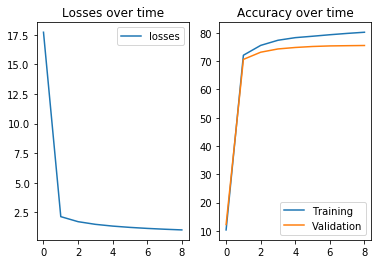

In [19]:
num_steps = 801
losses, train_acc, valid_acc = [],[],[]

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as 
    # we described in the graph: random weights for the matrix, zeros for the biases.
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the predictions returned as numpy
        # arrays
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            losses.append(l)
            print('Loss at step %d: %f' % (step,l))
            acc = accuracy(predictions, train_labels[:train_subset, :])
            train_acc.append(acc)
            print('Training accuracy: %0.1f%%' % acc)
            # calling .eval() on valid_prediction is basically like calling run(), but 
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            acc= accuracy(valid_prediction.eval(), valid_labels)
            valid_acc.append(acc)
            print('Validation accuracy: %.1f%%' % acc)
            print('.'*25)
    print('test accuracy: %.1f%%' % accuracy(test_prediction.eval(),test_labels))

plt.subplot(1,2,1)
plt.plot(losses)
plt.legend(['losses'])
plt.title('Losses over time')
plt.subplot(1,2,2)
plt.plot(train_acc)
plt.plot(valid_acc)
plt.title('Accuracy over time')
plt.legend(['Training', 'Validation'])
plt.show()

### Stochastic Gradient Descent

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all training data into a constant node, we create a Placeholder node which will be fed actual data at every all of session.run()

**1. Load Data and Build Computation Graph**

**Placeholders**
* tf_train_dataset isn't a specific value.
* It's a placeholder, a value that we'll input when we ask TensorFlow to run a computation.
* We represent this 2-D tensor of floating-point numbers, with a shape ```[batch_size, image_size*image_size]```
* If there is None, it means that a dimension can be of any length.


In [24]:
batch_size = 128
train_subset = 10000

graph = tf.Graph()
with graph.as_default():
    # Input data for the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size*image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights)+biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights)+biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights)+biases)
    

**2. Run Computation and Interrate**

let's run this computation and Iterate:

Initialized
Loss at step 0: 17.150896
Training accuracy: 11.7%
Validation accuracy: 12.6%
.........................
Loss at step 500: 1.780329
Training accuracy: 74.2%
Validation accuracy: 75.5%
.........................
Loss at step 1000: 1.112576
Training accuracy: 78.9%
Validation accuracy: 76.7%
.........................
Loss at step 1500: 0.811056
Training accuracy: 84.4%
Validation accuracy: 77.4%
.........................
Loss at step 2000: 0.714929
Training accuracy: 82.8%
Validation accuracy: 78.0%
.........................
Loss at step 2500: 0.943676
Training accuracy: 75.8%
Validation accuracy: 77.7%
.........................
Loss at step 3000: 0.945463
Training accuracy: 74.2%
Validation accuracy: 78.8%
.........................
test accuracy: 85.9%


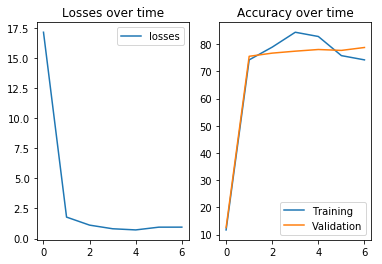

In [26]:
num_epochs = 3001
losses, train_acc, valid_acc = [],[],[]

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for epoch in range(num_epochs):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (epoch*batch_size)%(train_labels.shape[0]-batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (epoch%500==0):
            losses.append(l)
            print('Loss at step %d: %f' % (epoch,l))
            acc = accuracy(predictions, batch_labels)
            train_acc.append(acc)
            print('Training accuracy: %0.1f%%' % acc)
            # calling .eval() on valid_prediction is basically like calling run(), but 
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            acc= accuracy(valid_prediction.eval(), valid_labels)
            valid_acc.append(acc)
            print('Validation accuracy: %.1f%%' % acc)
            print('.'*25)
    print('test accuracy: %.1f%%' % accuracy(test_prediction.eval(),test_labels))

plt.subplot(1,2,1)
plt.plot(losses)
plt.legend(['losses'])
plt.title('Losses over time')
plt.subplot(1,2,2)
plt.plot(train_acc)
plt.plot(valid_acc)
plt.title('Accuracy over time')
plt.legend(['Training', 'Validation'])
plt.show()

### Offset Explanation

* The offset gives an arithmetic sequence within each epoch and different offsets can be obtained among different epochs.
    * Epoch:
         * Measure of the number of times all of the training vectors are used once to update the weights.
         * For batch training, all of the training samples pass through the learning algorithm simultaneously in one epoch before weights are updated.
         * For sequential training, all of the weights are updated after each training vector is sequentially passed through the training algorithm.
* The expression for the offset generates a cyclic group of numbers. These offsets make each mini-batch different from each other not only within each epoch but also among epochs.
* The reason why we randomly shift the batch_data is that if you sample a dataset according to a distribution P enough times, then you can estimate the expectation value for the dataset. In other words, you can estimate the loss function over the training dataset by randomly choosing each mini-batch dataset.
* Example: batch_size = 3 and size of train_labels = 100:
   * steps = 1,2,...,32
       * offset = 3,6,...,96
   *  steps = 33,34,...,64
       * offset = 2,5,..,95
   * for steps = 65,66,...,96
       * offset = 1,4,..,94, and so on.



## Problem
Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/api_docs/python/tf/nn#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

In [28]:
batch_size = 128
num_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data for the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training ReLU layer.
    logits_1 = tf.matmul(tf_train_dataset, weights_1)+biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2)+biases_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits_2))    
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training data.
    train_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for validation data.
    logits_1 = tf.matmul(tf_valid_dataset, weights_1)+biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2)+biases_2
    valid_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for test data.
    logits_1 = tf.matmul(tf_test_dataset, weights_1)+biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2)+biases_2
    test_prediction = tf.nn.softmax(logits_2)

Initialized
Loss at step 0: 355.797180
Training accuracy: 11.7%
Validation accuracy: 32.6%
.........................
Loss at step 500: 18.746025
Training accuracy: 79.7%
Validation accuracy: 81.1%
.........................
Loss at step 1000: 6.488556
Training accuracy: 84.4%
Validation accuracy: 80.6%
.........................
Loss at step 1500: 15.228055
Training accuracy: 83.6%
Validation accuracy: 80.5%
.........................
Loss at step 2000: 1.089463
Training accuracy: 85.9%
Validation accuracy: 81.7%
.........................
Loss at step 2500: 3.883020
Training accuracy: 82.0%
Validation accuracy: 81.5%
.........................
Loss at step 3000: 15.026422
Training accuracy: 71.1%
Validation accuracy: 77.8%
.........................
test accuracy: 84.8%


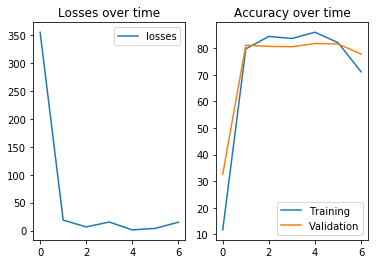

In [29]:
num_steps = 3001
losses, train_acc, valid_acc = [],[],[]

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step*batch_size)%(train_labels.shape[0]-batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step%500==0):
            losses.append(l)
            print('Loss at step %d: %f' % (step,l))
            acc = accuracy(predictions, batch_labels)
            train_acc.append(acc)
            print('Training accuracy: %0.1f%%' % acc)
            # calling .eval() on valid_prediction is basically like calling run(), but 
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            acc= accuracy(valid_prediction.eval(), valid_labels)
            valid_acc.append(acc)
            print('Validation accuracy: %.1f%%' % acc)
            print('.'*25)
    print('test accuracy: %.1f%%' % accuracy(test_prediction.eval(),test_labels))

plt.subplot(1,2,1)
plt.plot(losses)
plt.legend(['losses'])
plt.title('Losses over time')
plt.subplot(1,2,2)
plt.plot(train_acc)
plt.plot(valid_acc)
plt.title('Accuracy over time')
plt.legend(['Training', 'Validation'])
plt.show()